Loading json in memory ...
used time: 0.880646 s
Loading json in memory ...
creating index...
index created!
used time: 0.406916 s
总共包含图片 2 张
第 1 张图片的高和宽分别为: (612, 612)
第 2 张图片的高和宽分别为: (500, 333)


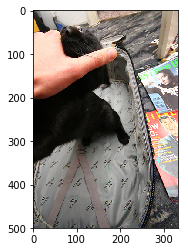

In [1]:
import cv2
from matplotlib import pyplot as plt
import numpy as np

# 载入 coco 相关 api
import sys
sys.path.append(r'D:\API\cocoapi\PythonAPI')
from pycocotools.dataset import Loader
%matplotlib inline

dataType = 'val2017'
root = 'E:/Data/coco'
catNms = ['cat', 'dog', 'person']  # 选择包含 'cat', 'dog', 'person' 的图片
annType = 'annotations_trainval2017'

loader = Loader(dataType, catNms, root, annType)

print(f'总共包含图片 {len(loader)} 张')

for i, ann in enumerate(loader.images):
    w, h = ann['height'], ann['width']
    print(f'第 {i+1} 张图片的高和宽分别为: {w, h}')

img, labels = loader[1]
plt.imshow(img);

In [2]:
cd ../app/

D:\API\CV\app


In [8]:
from mxnet import nd, init, gluon, autograd
from mxnet.gluon import nn

from gluoncv.model_zoo import vgg16
from gluoncv.nn.coder import NormalizedBoxCenterDecoder
from gluoncv.nn.bbox import BBoxCornerToCenter, BBoxClipToImage

from detection.bbox import MultiBox, BoxTransform
from detection.anchor import RPNAnchorGenerator


class RPNProposal(nn.HybridBlock):
    def __init__(self, channels, stride, base_size, ratios, scales, alloc_size, **kwargs):
        super().__init__(**kwargs)
        weight_initializer = init.Normal(0.01)

        with self.name_scope():
            self.anchor_generator = RPNAnchorGenerator(
                stride, base_size, ratios, scales, alloc_size)
            anchor_depth = self.anchor_generator.num_depth
            self.conv1 = nn.HybridSequential()
            self.conv1.add(nn.Conv2D(channels, 3, 1, 1,
                                     weight_initializer=weight_initializer))
            self.conv1.add(nn.Activation('relu'))
            # use sigmoid instead of softmax, reduce channel numbers
            self.score = nn.Conv2D(anchor_depth, 1, 1, 0,
                                   weight_initializer=weight_initializer)
            self.loc = nn.Conv2D(anchor_depth * 4, 1, 1, 0,
                                 weight_initializer=weight_initializer)


def getX(img):
    # 将 img (h, w, 3) 转换为 (1, 3, h, w)
    img = img.transpose((2, 0, 1))
    return np.expand_dims(img, 0)


def size_control(F, min_size, rois, scores):
    # 拆分坐标
    xmin, ymin, xmax, ymax = rois.split(axis=-1, num_outputs=4)
    width = xmax - xmin  # 锚框宽度的集合
    height = ymax - ymin  # # 锚框高度的集合
    # 获取所有小于 min_size 的高宽
    invalid = (width < min_size) + (height < min_size)  # 同时满足条件
    # 将不满足条件的锚框的坐标与得分均设置为 -1
    scores = F.where(invalid, F.ones_like(invalid) * -1, scores)
    invalid = F.repeat(invalid, axis=-1, repeats=4)
    rois = F.where(invalid, F.ones_like(invalid) * -1, rois)
    return rois, scores


def group_ious(pred_bbox, true_bbox):
    # 计算 pred_bbox 与 true_bbox 的 IoU 组合
    GT = [Box(corner) for corner in true_bbox]  # 真实边界框实例化
    G = [Box(corner) for corner in pred_bbox]   # 预测边界框实例化
    ious = np.zeros((len(G), len(GT)))  # 初始化 IoU 的计算
    for i, A in enumerate(G):
        for j, B in enumerate(GT):
            iou = A.IoU(B)
            ious[i, j] = iou
    return ious


# PRN 前期的设定
channels = 256   # conv1 的输出通道数
base_size = 2**4  # 特征图的每个像素的感受野大小
scales = [8, 16, 32]  # 锚框相对于 reference box 的尺度
ratios = [0.5, 1, 2]  # reference box 与锚框的高宽的比率（aspect ratios）
stride = base_size  # 在原图上滑动的步长
alloc_size = (128, 128)  # 一个比较大的特征图的锚框生成模板
# 用来辅助理解 RPN 的类
self = RPNProposal(channels, stride, base_size, ratios, scales, alloc_size)
self.initialize()   # 初始化卷积层 conv1, loc, score
stds = (0.1, 0.1, 0.2, 0.2)  # 偏移量的标准差
means = (0., 0., 0., 0.)    # 偏移量的均值
# 锚框的编码
box_to_center = BBoxCornerToCenter()  # 将 (xmin,ymin,xmax,ymax) 转换为 (x,y,w,h)
# 将锚框通过偏移量进行修正，并解码为 (xmin,ymin,xmax,ymax)
box_decoder = NormalizedBoxCenterDecoder(stds, means)
clipper = BBoxClipToImage()  # 裁剪超出原图尺寸的边界
# 获取 COCO 的一张图片用来做实验
img, label = loader[0]   # 获取一张图片
img = cv2.resize(img, (800, 800))  # resize 为 (800, 800)
imgs = nd.array(getX(img))      # 转换为 MXNet 的输入形式
# 提取最后一层卷积的特征
net = vgg16(pretrained=True)    # 载入基网络的权重
features = net.features[:29]    # 卷积层特征提取器
fs = features(imgs)  # 获取特征图张量
A = self.anchor_generator(fs)    # 生成 (xmin,ymin,xmax,ymax) 形式的锚框
B = box_to_center(A)      # 编码 为(x,y,w,h) 形式的锚框
x = self.conv1(fs)    # conv1 卷积
# sigmoid 激活之前的 score
raw_rpn_scores = self.score(x).transpose(axes=(0, 2, 3, 1)).reshape((0, -1, 1))
rpn_scores = nd.sigmoid(nd.stop_gradient(raw_rpn_scores))    # 激活后的 score
# loc 预测偏移量 (tx,ty,tw,yh)
rpn_box_pred = self.loc(x).transpose(axes=(0, 2, 3, 1)).reshape((0, -1, 4))
roi = box_decoder(rpn_box_pred, B)  # 解码后的预测边界框 G（RoIs）
print(roi.shape)   # 裁剪之前
roi = clipper(roi, imgs)  # 裁剪超出原图尺寸的边界


# nms 参数设定
nms_thresh = 0.7  # nms 的阈值
min_size = 16  # 最小锚框的尺寸
pre_nms = 12000  # nms 之前的 bbox 的数目
post_nms = 2000  # ms 之后的 bbox 的数目

# Non-maximum suppression
pre = nd.concat(rpn_scores, roi, dim=-1)
tmp = nd.contrib.box_nms(pre, overlap_thresh=nms_thresh, topk=pre_nms,
                                    coord_start=1, score_index=0, id_index=-1, force_suppress=True)

# slice post_nms number of boxes
result = nd.slice_axis(tmp, axis=1, begin=0, end=post_nms)
rpn_scores = nd.slice_axis(result, axis=-1, begin=0, end=1)
rpn_bbox = nd.slice_axis(result, axis=-1, begin=1, end=None)
print(rpn_scores.shape)

(1, 22500, 4)
(1, 2000, 1)


In [12]:
loader.coco.keys()

dict_keys(['dataset', 'anns', 'imgToAnns', 'catToImgs', 'imgs', 'cats'])

In [14]:
loader.coco.cats

{1: {'supercategory': 'person', 'id': 1, 'name': 'person'},
 2: {'supercategory': 'vehicle', 'id': 2, 'name': 'bicycle'},
 3: {'supercategory': 'vehicle', 'id': 3, 'name': 'car'},
 4: {'supercategory': 'vehicle', 'id': 4, 'name': 'motorcycle'},
 5: {'supercategory': 'vehicle', 'id': 5, 'name': 'airplane'},
 6: {'supercategory': 'vehicle', 'id': 6, 'name': 'bus'},
 7: {'supercategory': 'vehicle', 'id': 7, 'name': 'train'},
 8: {'supercategory': 'vehicle', 'id': 8, 'name': 'truck'},
 9: {'supercategory': 'vehicle', 'id': 9, 'name': 'boat'},
 10: {'supercategory': 'outdoor', 'id': 10, 'name': 'traffic light'},
 11: {'supercategory': 'outdoor', 'id': 11, 'name': 'fire hydrant'},
 13: {'supercategory': 'outdoor', 'id': 13, 'name': 'stop sign'},
 14: {'supercategory': 'outdoor', 'id': 14, 'name': 'parking meter'},
 15: {'supercategory': 'outdoor', 'id': 15, 'name': 'bench'},
 16: {'supercategory': 'animal', 'id': 16, 'name': 'bird'},
 17: {'supercategory': 'animal', 'id': 17, 'name': 'cat'},